# Project Name: Lyric Generator
Description:
Implementing a Deep Neural network using LSTMs to create a character based lyric generator

Details:
1. step size: 40
2. batch size: 128
3. Epochs: 100
4. Songs: 1000

### Importing Libraries

In [32]:
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers import Activation,LSTM,Dense,CuDNNLSTM, Flatten, Bidirectional, Dropout
from keras.optimizers import Adam
import pandas as pd
import numpy as np
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
import os
import matplotlib.pyplot as plt
import math
np.random.seed(10)

### Design Parameters

In [2]:
BATCH_SIZE = 128
maxlen = 40 ##timesteps
epochs = 60
# MIN_WORD_FREQUENCY = 10
song_count = 1000

In [3]:
def load_lyrics(path):
    '''
    Function to load lyrics of all the artists in the input path
    '''
    lyrics = ""
    for fn in os.listdir(path):
        with open(os.path.join(path, fn), 'r') as song:
            song_lyrics = clean_string(song.read())
            lyrics += song_lyrics
    return lyrics

def clean_string(string):
    """
    Cleans unwanted characters and words from string.
    @param string: The string to be cleaned.
    @return: The cleaned string.
    """
    string = string.lower()  # lowercase

    clean_words = []
    for word in string.split():
        # clean words with quotation marks on only one side
        if word[0] == '"' and word[-1] != '"':
            word = word[1:]
        elif word[-1] == '"' and word[0] != '"':
            word = word[-1]

        # clean words with parenthases on only one side
        if word[0] == '(' and word[-1] != ')':
            word = word[1:]
        elif word[-1] == ')' and word[0] != '(':
            word = word[:-1]

        clean_words.append(word)
    return ' '.join(clean_words)

### Reading Input
Parameters: 10 songs

In [4]:
# ## Reading the scraped Rap songs
# text = load_lyrics("./RapLyrics-Scraper/my_lyrics_folder/")

In [5]:
## Reading the kaggle input ~55k songs
df=pd.read_csv('./songdata.csv')['text'][:song_count]
data=np.array(df)

In [6]:
# ## Reading the scraped pink floyed songs
# df=pd.read_csv('./pink_floyd_lyrics.csv',header=0, error_bad_lines=False, delimiter='\t')['text']
# df = df.fillna('')
# data=np.array(df)

### Creating corpus(all the characters in all the songs concatenated)
1. Converting all the characters to lower

In [7]:
corpus=''
for ix in range(len(data)):
    corpus+=data[ix]
corpus = corpus.lower()
corpus = clean_string(corpus)
# corpus = text

### Creating Vocabulary and char, index mappings

In [8]:
vocab=list(set(corpus))
char_ix={c:i for i,c in enumerate(vocab)}
ix_char={i:c for i,c in enumerate(vocab)}

### Setting up the timesteps

In [9]:
vocab_size=len(vocab) ##Dimensions of each char
print(vocab_size)
print(vocab)

49
[' ', 'p', '.', '-', 'u', 'o', '9', 'n', 'k', '8', 't', 'c', 'w', 'z', "'", 'q', 'd', 'f', 'i', 's', '5', '6', '1', '"', '(', 'a', 'b', 'v', 'g', '3', '7', '?', '2', '0', ':', ']', '!', 'h', 'x', 'j', 'l', '4', 'r', 'e', 'y', 'm', ',', '[', ')']


In [10]:
len(corpus)

1084724

### Creating the train and test datasets

In [11]:
sentences=[]
next_char=[]
for i in range(len(corpus)-maxlen-1):
    sentences.append(corpus[i:i+maxlen])
    next_char.append(corpus[i+maxlen])
split_count = int(0.8 * len(corpus))
sentences_test = sentences[split_count:]
next_char_test = next_char[split_count:]
sentences = sentences[:split_count]
next_char = next_char[:split_count]

In [12]:
def generator(sentence_list, next_word_list, batch_size):
    '''
    Generator function to generate the input/output data using
    generators concept(to avoid RAM overflow)
    '''
    index = 0
    while True:
        x = np.zeros((batch_size, maxlen, vocab_size), dtype=np.bool)
        y = np.zeros((batch_size, vocab_size), dtype=np.bool)
        for i in range(batch_size):
            for t, w in enumerate(sentence_list[index]):
                x[i, t, char_ix[w]] = 1
            y[i, char_ix[next_word_list[index]]] = 1

            index = index + 1
            if index == len(sentence_list):
                index = 0
        yield x, y

In [13]:
def create_model(timesteps, vocab_size, no_layers=2):
    '''
    Creating the model
    '''
    model=Sequential()
    model.add(CuDNNLSTM(128,input_shape=(timesteps,vocab_size)))
#     for i in range(no_layers):
#         model.add(Bidirectional(CuDNNLSTM(128,input_shape=(timesteps,vocab_size), return_sequences=True)))
#     model.add(Flatten())
    model.add(Dense(vocab_size))
    model.add(Activation('softmax'))
    model.summary()
    model.compile(optimizer=Adam(lr=0.01),loss='categorical_crossentropy')
    return model

In [14]:
model = create_model(maxlen, vocab_size)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 128)               91648     
_________________________________________________________________
dense_1 (Dense)              (None, 49)                6321      
_________________________________________________________________
activation_1 (Activation)    (None, 49)                0         
Total params: 97,969
Trainable params: 97,969
Non-trainable params: 0
_________________________________________________________________


In [15]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def on_epoch_end(epoch, logs):
    '''
    Callback function to write output to file after each epoch
    '''
    # Function invoked at end of each epoch. Prints generated text.
    examples_file.write('\n----- Generating text after Epoch: %d\n' % epoch)

    # Randomly pick a seed sequence
    seed_index = np.random.randint(len(sentences+sentences_test))
    seed = (sentences+sentences_test)[seed_index]

    for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
        sentence = seed
        examples_file.write('----- Diversity:' + str(diversity) + '\n')
        examples_file.write('----- Generating with seed:\n"' + ' '.join(sentence) + '"\n')
        examples_file.write(' '.join(sentence))

        for i in range(50):
            x_pred = np.zeros((1, maxlen, vocab_size))
            for t, word in enumerate(sentence):
                x_pred[0, t,char_ix[word]] = 1

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char_pred = ix_char[next_index]

            sentence = sentence[1:]
#             print(sentence)
            sentence += next_char_pred

            examples_file.write(" "+next_char_pred)
        examples_file.write('\n')
    examples_file.write('='*80 + '\n')
#     examples_file.flush()

### Opening the output file

In [16]:
examples_file = open("output_data.txt", "w")

### Training the model

In [17]:
file_path = "./checkpoints/LSTM_LYRICS-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-loss{loss:.4f}-acc{acc:.4f}-val_loss{val_loss:.4f}-val_acc{val_acc:.4f}" % (
    len(vocab),
    maxlen,
    10
)
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True)

checkpoint_path = "cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
callbacks_list = [print_callback, cp_callback, early_stopping]
history = model.fit_generator(generator(sentences, next_char, BATCH_SIZE),
    steps_per_epoch=int(len(sentences)/BATCH_SIZE) + 1,
    epochs=epochs,
    validation_data=generator(sentences_test, next_char_test, BATCH_SIZE)
                    ,validation_steps=int(len(sentences_test)/BATCH_SIZE) + 1,
                   callbacks = callbacks_list)

Instructions for updating:
Use tf.cast instead.
Epoch 1/60
6780/6780 [==============================] - 49s 7ms/step - loss: 1.6372 - val_loss: 1.6010

Epoch 00001: saving model to cp.ckpt
Epoch 2/60
6780/6780 [==============================] - 45s 7ms/step - loss: 1.4535 - val_loss: 1.5539

Epoch 00002: saving model to cp.ckpt
Epoch 3/60
6780/6780 [==============================] - 44s 7ms/step - loss: 1.4098 - val_loss: 1.5334

Epoch 00003: saving model to cp.ckpt
Epoch 4/60
6780/6780 [==============================] - 45s 7ms/step - loss: 1.3868 - val_loss: 1.5239

Epoch 00004: saving model to cp.ckpt
Epoch 5/60
6780/6780 [==============================] - 44s 7ms/step - loss: 1.3718 - val_loss: 1.5120

Epoch 00005: saving model to cp.ckpt
Epoch 6/60
6780/6780 [==============================] - 43s 6ms/step - loss: 1.3599 - val_loss: 1.5095

Epoch 00006: saving model to cp.ckpt
Epoch 7/60
6780/6780 [==============================] - 43s 6ms/step - loss: 1.3529 - val_loss: 1.5051

Ep

/home/iwonttellyouthat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.



Epoch 00008: saving model to cp.ckpt
Epoch 9/60
6780/6780 [==============================] - 44s 6ms/step - loss: 1.3417 - val_loss: 1.5030

Epoch 00009: saving model to cp.ckpt
Epoch 10/60
6780/6780 [==============================] - 43s 6ms/step - loss: 1.3388 - val_loss: 1.5153

Epoch 00010: saving model to cp.ckpt
Epoch 11/60
6780/6780 [==============================] - 45s 7ms/step - loss: 1.3349 - val_loss: 1.5034

Epoch 00011: saving model to cp.ckpt
Epoch 12/60
6780/6780 [==============================] - 44s 7ms/step - loss: 1.3391 - val_loss: 1.5044

Epoch 00012: saving model to cp.ckpt
Epoch 13/60
6780/6780 [==============================] - 44s 7ms/step - loss: 1.3349 - val_loss: 1.5030

Epoch 00013: saving model to cp.ckpt


### Closing the output file

In [18]:
examples_file.close()

### Plotting Train Loss curve

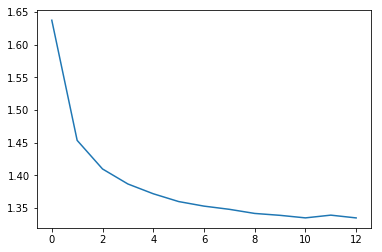

In [19]:
plt.plot(history.history['loss'])

In [40]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
plt.plot(history.history['loss'])
fig.savefig('Train_loss.png')   # save the figure to file
plt.close(fig)    # close the figure

### Plotting Validation Loss curve

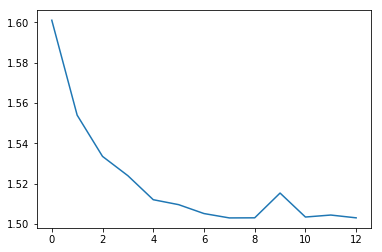

In [20]:
plt.plot(history.history['val_loss'])

In [41]:
fig, ax = plt.subplots( nrows=1, ncols=1 )  # create figure & 1 axis
plt.plot(history.history['val_loss'])
fig.savefig('Val_loss.png')   # save the figure to file
plt.close(fig)    # close the figure

### Saving the model to disk

In [21]:
model.save('keras_model_char.hdf5')
# loaded_model = keras.models.load_model('keras_model_char.hdf5')

### Loading the model

In [22]:
#loaded_model = keras.models.load_model('keras_model.hdf5')

In [23]:
def sample(preds, temperature=1.0):
    '''
    Function to sample a character from the a given
    list of probs
    '''
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [30]:
print(seed)

[chorus] i've never been so satisfied wi


### Testing the model

In [39]:
# Randomly pick a seed sequence
# seed_index = np.random.randint(len(sentences_test))
# seed = sentences_test[seed_index]
seed_index = -150
seed = corpus[-seed_index:-seed_index+maxlen]
print("----- Actual")
print(corpus[-seed_index:-seed_index+maxlen+100])
print()

for diversity in [0.3, 0.4, 0.5, 0.6, 0.7]:
    sentence = seed
    print('----- Diversity:' + str(diversity) + '\n')
    print('----- Generating with seed:\n"' + ''.join(sentence) + '"\n')
    print(''.join(sentence))

    for i in range(100):
        x_pred = np.zeros((1, maxlen, vocab_size))
        for t, word in enumerate(sentence):
            x_pred[0, t,char_ix[word]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, diversity)
        next_char_pred = ix_char[next_index]

        sentence = sentence[1:]
#             print(sentence)
        sentence += next_char_pred

        print(""+next_char_pred, end="")
    print('\n')
print('='*80 + '\n')

----- Actual
 be? she's just my kind of girl, she makes me feel fine who could ever believe that she could be mine? she's just my kind of girl, without h

----- Diversity:0.3

----- Generating with seed:
" be? she's just my kind of girl, she mak"

 be? she's just my kind of girl, she mak
e the storm for the rain and i can be the song and i can be some to the wind the sun when i saw the 

----- Diversity:0.4

----- Generating with seed:
" be? she's just my kind of girl, she mak"

 be? she's just my kind of girl, she mak
e it and she's some more the side it's long and i was so there i was been i was so may stay and i ca

----- Diversity:0.5

----- Generating with seed:
" be? she's just my kind of girl, she mak"

 be? she's just my kind of girl, she mak
e a sun in me and i roll me by the moon and i saw me we don't some and with the wind the guitar in m

----- Diversity:0.6

----- Generating with seed:
" be? she's just my kind of girl, she mak"

 be? she's just my kind of girl, she mak
e t

/home/iwonttellyouthat/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


wind i'm down with the wind man tonight of a foo

----- Diversity:0.7

----- Generating with seed:
" be? she's just my kind of girl, she mak"

 be? she's just my kind of girl, she mak
e in my sweet lullana i turn i can matted like it's been my come on the gate signed, i was over you 




### Testing the model

In [26]:
# txt = corpus
# start_index = 230

generated = ''
actual = ''
# sent=txt[start_index:start_index+maxlen]
sent = sentences_test[0]
generated += sent
actual += sent
print("Input - ",generated)
gen = generated
for i in range(100):
    x_sample=generated[i:i+maxlen]
    x = np.zeros((1,maxlen,vocab_size))
    for j in range(maxlen):
        x[0,j,char_ix[x_sample[j]]] = 1
    probs = model.predict(x)
    probs = np.reshape(probs,probs.shape[1])
#     ix = np.argmax(probs)
    ix=np.random.choice(range(vocab_size),p=probs.ravel())
    generated += ix_char[ix]
    actual += next_char_test[i]
# for i in range(100):
#     x_sample=gen[i:i+maxlen]
#     x=np.zeros((1,maxlen,vocab_size))
#     for j in range(maxlen):
#         x[0,j,char_ix[x_sample[j]]]=1
#     probs=loaded_model.predict(x)[0]
#     ix = np.argmax(probs)
# #     ix=np.random.choice(range(vocab_size),p=probs.ravel())
#     gen+=ix_char[ix]
# # print("--------------")

Input -   that's a start chorus: i'll take to the


In [27]:
print("Generated - ")
print(generated)
print()
print("Actual -")
print(actual)

Generated - 
 that's a start chorus: i'll take to the midgplikes for the man flying hati to poly the song time of ver music on. cn. tild this light a fla

Actual -
 that's a start chorus: i'll take to the road in a little while under cover of night you come or you stay whatever seems right i ain't looki


### Credits